# Differentially Private Hate Speech Detection - Opacus

# Data Preprocessing

In [8]:
import pandas as pd

df = pd.read_csv('white-supremacist-forum.csv')
df

,Unnamed: 0,text,label
0,0,"As of March 13th , 2014 , the booklet had been...",noHate
1,1,In order to help increase the booklets downloa...,noHate
2,2,( Simply copy and paste the following text int...,noHate
3,3,Click below for a FREE download of a colorfull...,hate
4,4,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...,noHate
...,...,...,...
10939,10939,"Billy - `` That guy would n't leave me alone ,...",noHate
10940,10940,Wish we at least had a Marine Le Pen to vote f...,noHate
10941,10941,Its like the choices are white genocide candid...,noHate
10942,10942,Why White people used to say that sex was a si...,hate


In [9]:
# 4 kinds of labels exist
df['label'].value_counts()

label
noHate      9507
hate        1196
relation     168
idk/skip      73
Name: count, dtype: int64

In [10]:
# filter invalid label
correctLabels = ['noHate', 'hate']
df = df.loc[df['label'].isin(correctLabels)]
df['label'].value_counts()

label
noHate    9507
hate      1196
Name: count, dtype: int64

In [11]:
df['text'].value_counts()

text
2508                                                                                                                          21
- YouTube                                                                                                                     11
Aragorn                                                                                                                        9
Exactly.                                                                                                                       8
14/88                                                                                                                          7
                                                                                                                              ..
That'll be a ONE person average per county , and a sub on the bench in case anyone gets injured .                              1
One !!!!! per county , ....... heartbreaking ..... absolutely heartbreaking .               

In [12]:
df

,Unnamed: 0,text,label
0,0,"As of March 13th , 2014 , the booklet had been...",noHate
1,1,In order to help increase the booklets downloa...,noHate
2,2,( Simply copy and paste the following text int...,noHate
3,3,Click below for a FREE download of a colorfull...,hate
4,4,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...,noHate
...,...,...,...
10939,10939,"Billy - `` That guy would n't leave me alone ,...",noHate
10940,10940,Wish we at least had a Marine Le Pen to vote f...,noHate
10941,10941,Its like the choices are white genocide candid...,noHate
10942,10942,Why White people used to say that sex was a si...,hate


# EDA

In [13]:
# Get descriptive summary for numerical features
summary_numeric = df.describe()

# Include categorical data in the summary
summary_all = df.describe(include='all')

print("Summary for Numerical Features:")
print(summary_numeric)

print("\nSummary for All Features (Numerical and Categorical):")
print(summary_all)

Summary for Numerical Features:
         Unnamed: 0
count  10703.000000
mean    5456.617584
std     3158.805803
min        0.000000
25%     2726.500000
50%     5460.000000
75%     8179.500000
max    10943.000000

Summary for All Features (Numerical and Categorical):
          Unnamed: 0   text   label
count   10703.000000  10703   10703
unique           NaN  10534       2
top              NaN   2508  noHate
freq             NaN     21    9507
mean     5456.617584    NaN     NaN
std      3158.805803    NaN     NaN
min         0.000000    NaN     NaN
25%      2726.500000    NaN     NaN
50%      5460.000000    NaN     NaN
75%      8179.500000    NaN     NaN
max     10943.000000    NaN     NaN


In [14]:
# Check for any null values in each column
null_values = df.isnull().any()

print("Columns with Null Values:")
print(null_values)

Columns with Null Values:
Unnamed: 0    False
text          False
label         False
dtype: bool


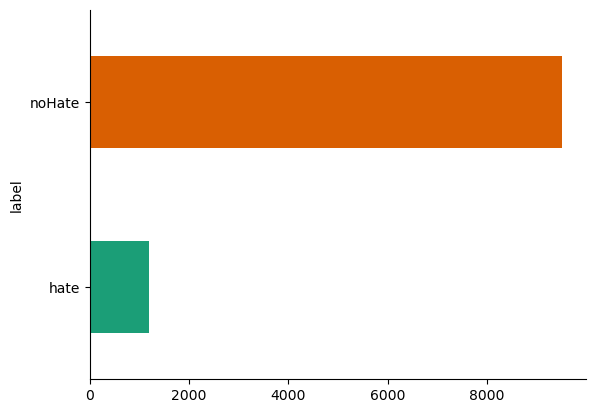

In [51]:
# label

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Data preparation for ML model

In [52]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def encode_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

In [53]:
from torch.utils.data import Dataset, DataLoader

class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

## Experiment: Oversampling

In [74]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
train_texts_resampled, train_labels_resampled = ros.fit_resample(df['text'].to_frame(), df['label'].to_frame())

In [75]:
train_texts_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19014 entries, 0 to 19013
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    19014 non-null  object
dtypes: object(1)
memory usage: 148.7+ KB


In [76]:
train_labels_resampled.value_counts()

label 
hate      9507
noHate    9507
Name: count, dtype: int64

In [77]:
train_texts_resampled = train_texts_resampled.squeeze()
train_labels_resampled = train_labels_resampled.squeeze()

In [78]:
from sklearn.model_selection import train_test_split

# Initial split to separate out the test set
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    train_texts_resampled, train_labels_resampled, test_size=0.1, random_state=42)

# Further split the training set into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels, test_size=0.1, random_state=42)

In [79]:
train_labels

14342      hate
16096      hate
1785       hate
13809      hate
342      noHate
          ...  
8557     noHate
4524       hate
13667      hate
993      noHate
4799     noHate
Name: label, Length: 15400, dtype: object

In [80]:
import numpy as np
# Convert labels to numeric
label_mapping = {'noHate': 0, 'hate': 1}
train_labels = train_labels.map(label_mapping)
test_labels = test_labels.map(label_mapping)

## Experiment: Undersampling

In [26]:
from collections import Counter
from imblearn.under_sampling import AllKNN
allknn = AllKNN()
train_texts_res, train_labels_res = allknn.fit_resample(train_texts, train_labels)
print('raw dataset shape %s' % Counter(train_labels))
print('Resampled dataset shape %s' % Counter(train_labels_res))

ValueError: could not convert string to float: 'Looking for seriour-or-less-than-less friends of like-minded people .'

In [81]:
# Preprocess texts
train_encodings = encode_texts(train_texts.tolist())
val_encodings = encode_texts(val_texts.tolist())
test_encodings = encode_texts(test_texts.tolist())

In [82]:
# Prepare datasets
train_dataset = HateSpeechDataset(train_encodings, train_labels.tolist())
val_dataset = HateSpeechDataset(val_encodings, val_labels.tolist())
test_dataset = HateSpeechDataset(test_encodings, test_labels.tolist())

# Baseline Model Training

In [83]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [84]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

# Define your training loop, including batch processing, optimization, and validation

/opt/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [85]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report

def evaluate(model, dataset, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=16):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            label = batch['labels'].to(device).to(torch.long)  # Ensure labels are long
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(label.cpu().numpy())

    model.train() # turn back to training mode
    # Calculate and print metrics
    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=['noHate', 'hate'])

    print(f"Accuracy: {accuracy}\n")
    print(report)

# Assuming you have a `device` variable set (e.g., to 'cuda' if using GPU)
evaluate(model, test_dataset)

/var/folders/t7/tn40jqq93xjgwnl_pngxhj440000gn/T/ipykernel_27126/1361201720.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Accuracy: 0.49158780231335436

              precision    recall  f1-score   support

      noHate       0.49      1.00      0.66       936
        hate       0.00      0.00      0.00       966

    accuracy                           0.49      1902
   macro avg       0.25      0.50      0.33      1902
weighted avg       0.24      0.49      0.32      1902



# Opacus

As the model is already pre-trained and we only plan to fine-tune a few upper layers, we want to freeze all layers, except for the last encoder and above (BertPooler and Classifier).

In [32]:
# freeze all layers, except for the last encoder and above (BertPooler and Classifier)
trainable_layers = [model.bert.encoder.layer[-1], model.bert.pooler, model.classifier]
total_params = 0
trainable_params = 0

for p in model.parameters():
        p.requires_grad = False
        total_params += p.numel()

for layer in trainable_layers:
    for p in layer.parameters():
        p.requires_grad = True
        trainable_params += p.numel()

In [33]:
BATCH_SIZE = 32
MAX_PHYSICAL_BATCH_SIZE = 8

In [34]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from opacus.utils.uniform_sampler import UniformWithReplacementSampler


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=BATCH_SIZE)

In [41]:
EPOCHS = 3
LOGGING_INTERVAL = 500 # once every how many steps we run evaluation cycle and report metrics
EPSILON = 7.5
DELTA = 1 / len(train_dataloader) # Parameter for privacy accounting. Probability of not achieving privacy guarantees

In [42]:
from opacus import PrivacyEngine

MAX_GRAD_NORM = 0.1

privacy_engine = PrivacyEngine()
model, optimizer, train_dataloader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_dataloader,
    target_delta=DELTA,
    target_epsilon=EPSILON, 
    epochs=EPOCHS,
    max_grad_norm=MAX_GRAD_NORM,
    poisson_sampling=False
)

/opt/anaconda3/lib/python3.11/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


In [43]:
# Move the model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
from opacus.utils.batch_memory_manager import BatchMemoryManager
from tqdm.notebook import tqdm
import numpy as np

for epoch in range(1, EPOCHS+1):
    losses = []

    with BatchMemoryManager(
        data_loader=train_dataloader, 
        max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE, 
        optimizer=optimizer
    ) as memory_safe_data_loader:
        for step, batch in enumerate(tqdm(memory_safe_data_loader)):
            optimizer.zero_grad()
            
            batch = tuple(t.to(device) for t in batch.values())
            
            inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'token_type_ids': batch[2],
                    'labels':         batch[3]}
            
            outputs = model(**inputs) # output = loss, logits, hidden_states, attentions

            loss = outputs[0]
            loss.backward()
            losses.append(loss.item())
            
            optimizer.step()

            if step > 0 and step % LOGGING_INTERVAL == 0:
                train_loss = np.mean(losses)
                eps = privacy_engine.get_epsilon(DELTA)

                evaluate(model, test_dataset)

                print(
                  f"Epoch: {epoch} | "
                  f"Step: {step} | "
                  f"Train loss: {train_loss:.3f} | "
                  f"ɛ: {eps:.2f}"
                )

  0%|          | 0/1084 [00:00<?, ?it/s]

/var/folders/t7/tn40jqq93xjgwnl_pngxhj440000gn/T/ipykernel_3663/2562756884.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 50 | Train loss: 0.956 | ɛ: 2.56


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 100 | Train loss: 0.914 | ɛ: 2.83


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 150 | Train loss: 0.888 | ɛ: 3.04


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 200 | Train loss: 0.839 | ɛ: 3.23


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 250 | Train loss: 0.819 | ɛ: 3.38


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 300 | Train loss: 0.814 | ɛ: 3.54


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 350 | Train loss: 0.839 | ɛ: 3.67


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 400 | Train loss: 0.854 | ɛ: 3.80


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 450 | Train loss: 0.858 | ɛ: 3.91


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 500 | Train loss: 0.857 | ɛ: 4.03


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 550 | Train loss: 0.862 | ɛ: 4.13


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 600 | Train loss: 0.870 | ɛ: 4.23


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 650 | Train loss: 0.862 | ɛ: 4.32


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 700 | Train loss: 0.875 | ɛ: 4.42


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 750 | Train loss: 0.885 | ɛ: 4.51


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 800 | Train loss: 0.881 | ɛ: 4.60


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 850 | Train loss: 0.893 | ɛ: 4.68


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 900 | Train loss: 0.885 | ɛ: 4.77


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 950 | Train loss: 0.882 | ɛ: 4.84


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 1000 | Train loss: 0.887 | ɛ: 4.93


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 1 | Step: 1050 | Train loss: 0.883 | ɛ: 5.00


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


  0%|          | 0/1084 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/t7/tn40jqq93xjgwnl_pngxh

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 50 | Train loss: 0.962 | ɛ: 5.13


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 100 | Train loss: 0.919 | ɛ: 5.20


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 150 | Train loss: 0.892 | ɛ: 5.27


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 200 | Train loss: 0.841 | ɛ: 5.35


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 250 | Train loss: 0.821 | ɛ: 5.41


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 300 | Train loss: 0.814 | ɛ: 5.49


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 350 | Train loss: 0.840 | ɛ: 5.55


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 400 | Train loss: 0.856 | ɛ: 5.62


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 450 | Train loss: 0.859 | ɛ: 5.69


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 500 | Train loss: 0.859 | ɛ: 5.76


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 550 | Train loss: 0.865 | ɛ: 5.82


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 600 | Train loss: 0.872 | ɛ: 5.88


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 650 | Train loss: 0.865 | ɛ: 5.95


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 700 | Train loss: 0.878 | ɛ: 6.01


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 750 | Train loss: 0.887 | ɛ: 6.07


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 800 | Train loss: 0.883 | ɛ: 6.14


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 850 | Train loss: 0.895 | ɛ: 6.19


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 900 | Train loss: 0.886 | ɛ: 6.26


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 950 | Train loss: 0.884 | ɛ: 6.31


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 1000 | Train loss: 0.889 | ɛ: 6.38


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 2 | Step: 1050 | Train loss: 0.885 | ɛ: 6.43


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


  0%|          | 0/1084 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/t7/tn40jqq93xjgwnl_pngxh

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 50 | Train loss: 0.959 | ɛ: 6.53


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 100 | Train loss: 0.913 | ɛ: 6.59


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 150 | Train loss: 0.890 | ɛ: 6.65


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 200 | Train loss: 0.839 | ɛ: 6.70


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 250 | Train loss: 0.820 | ɛ: 6.76


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 300 | Train loss: 0.814 | ɛ: 6.82


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 350 | Train loss: 0.841 | ɛ: 6.87


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 400 | Train loss: 0.856 | ɛ: 6.93


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 450 | Train loss: 0.859 | ɛ: 6.98


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 500 | Train loss: 0.857 | ɛ: 7.04


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 550 | Train loss: 0.863 | ɛ: 7.09


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 600 | Train loss: 0.870 | ɛ: 7.14


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 650 | Train loss: 0.864 | ɛ: 7.19


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 700 | Train loss: 0.876 | ɛ: 7.25


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 750 | Train loss: 0.885 | ɛ: 7.30


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 800 | Train loss: 0.882 | ɛ: 7.35


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 850 | Train loss: 0.893 | ɛ: 7.40


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 900 | Train loss: 0.884 | ɛ: 7.46


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 950 | Train loss: 0.882 | ɛ: 7.51


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 1000 | Train loss: 0.887 | ɛ: 7.56


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Accuracy: 0.8898225957049486

              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       953
        hate       0.00      0.00      0.00       118

    accuracy                           0.89      1071
   macro avg       0.44      0.50      0.47      1071
weighted avg       0.79      0.89      0.84      1071

Epoch: 3 | Step: 1050 | Train loss: 0.883 | ɛ: 7.61


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


## Opacus fine-tuned result
Accuracy: 0.8898225957049486

ɛ: 7.61